# Numerical Simulations, Markov Chain Monte Carlo

## The computational curse of Bayesian statistics

In Bayesian inference we want the **posterior** distribution of parameters $\theta$ given data $d$:

$$
p(\theta \mid d)
= \frac{p(d \mid \theta)\, p(\theta)}{p(d)}.
$$

The denominator is the **evidence** (or marginal likelihood)

$$
p(d)
= \int p(d \mid \theta)\, p(\theta)\, d\theta,
$$

or, for multiple parameters $\theta = (\theta_1, \dots, \theta_d)$,

$$
p(d)
= \int_{\mathbb{R}^d} p(d \mid \theta_1,\dots,\theta_d)\,
                         p(\theta_1,\dots,\theta_d)\,
                         d\theta_1 \cdots d\theta_d.
$$

This integral is often **not available in closed form** except for special **conjugate families**. Reasons:

- The prior $p(\theta)$ or likelihood $p(d \mid \theta)$ may be **multimodal**, **non-Gaussian**, or **non-parametric**.
- The parameter space is often **high-dimensional** (many parameters or latent variables).
- Realistic models (e.g. hierarchical models) create complicated dependency structures.

Because of this, the central problem of practical Bayesian statistics is **numerical approximation of the posterior**.

## Grid approximation and the curse of dimensionality

A simple numerical approach is **grid approximation**:

1. Choose a grid of parameter values $\{\theta^{(1)}, \dots, \theta^{(N)}\}$.
2. Evaluate the **unnormalized posterior**
   $$
   \tilde p(\theta^{(i)} \mid d) = p(d \mid \theta^{(i)})\, p(\theta^{(i)})
   $$
   at each grid point.
3. Normalize:
   $$
   p(\theta^{(i)} \mid d)
   = \frac{\tilde p(\theta^{(i)} \mid d)}{\sum_{j=1}^N \tilde p(\theta^{(j)} \mid d)}.
   $$

For a **single parameter**, a grid can work reasonably well.

However, for **$d$ parameters**, if we use $N$ grid points **per dimension**, we need

$$
N^d
$$

grid points in total.

This is the **curse of dimensionality**:

- Work grows **exponentially** with dimension $d$.
- Even modest values (e.g. $N=100$, $d=6$) become infeasible:
  $100^6 = 10^{12}$ grid points.

Hence, naive grid approximation is only practical for **very low-dimensional** problems where we roughly know the region
of interest in advance.

## Monte Carlo methods and Monte Carlo integration

**Monte Carlo methods** use random samples to solve deterministic problems such as computing expectations or integrals.

Suppose we want to compute the expectation of a function $f(\theta)$ under a distribution with PDF $p(\theta)$:

$$
\mathbb{E}_{p}[f(\theta)]
= \int f(\theta)\, p(\theta)\, d\theta.
$$

If we can sample independent draws $\theta^{(1)}, \dots, \theta^{(N)} \sim p(\theta)$, a Monte Carlo estimator is

$$
\widehat{\mathbb{E}}_{p}[f(\theta)]
= \frac{1}{N} \sum_{i=1}^{N} f\big(\theta^{(i)}\big).
$$

By the **law of large numbers**, this converges to the true expectation as $N \to \infty$.

For Bayesian inference, we would love to sample from the **posterior** and approximate posterior expectations this way:

$$
\mathbb{E}[f(\theta) \mid d]
= \int f(\theta)\, p(\theta \mid d)\, d\theta
\;\approx\;
\frac{1}{N} \sum_{i=1}^{N} f\big(\theta^{(i)}\big),
\quad \theta^{(i)} \sim p(\theta \mid d).
$$

The problem: we do **not** know how to sample from $p(\theta \mid d)$ directly. Plain Monte Carlo integration with the
**prior** $p(\theta)$ is often very inefficient, because most prior samples fall into regions of **very low likelihood**.

## Markov processes and Markov chains

To construct better sampling algorithms, we introduce **Markov processes**.

A stochastic process $\{X_t\}_{t=0}^{\infty}$ with values in some state space $\Omega$ is a **Markov process** if it satisfies
the **Markov property**:

$$
P(X_{t+1} = x_{t+1} \mid X_t = x_t, X_{t-1} = x_{t-1}, \dots, X_0 = x_0)
= P(X_{t+1} = x_{t+1} \mid X_t = x_t)
$$

for all $t$ and states $x_0,\dots,x_{t+1}$.

For a discrete state space $\Omega = \{1,\dots,K\}$, the process is characterized by:

- **Transition probabilities**
  $$
  P_{ij} = P(X_{t+1} = j \mid X_t = i),
  $$
- collected in a **transition matrix** $P$ with entries $P_{ij} \ge 0$ and $\sum_j P_{ij} = 1$.

A sequence of states $X_0, X_1, X_2, \dots$ generated by such a process is called a **Markov chain**.

The key idea for MCMC is: **construct a Markov chain whose stationary distribution is the posterior $p(\theta \mid d)$**.
Then, the chain will spend time in different regions of parameter space in proportion to their posterior probability.

## Random walks as simple continuous Markov processes

A simple continuous-state Markov process is a **random walk**.

One-dimensional example:

$$
\theta_{t+1} = \theta_t + \varepsilon_t,
\quad \varepsilon_t \sim \mathcal{N}(0, \sigma^2),
$$

where each $\varepsilon_t$ is an independent Gaussian “step”. The transition density (proposal) is

$$
q(\theta' \mid \theta)
= \mathcal{N}(\theta'; \theta, \sigma^2).
$$

Multivariate example in $\mathbb{R}^d$:

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t + \boldsymbol{\varepsilon}_t,
\quad \boldsymbol{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \Sigma),
$$

with covariance matrix $\Sigma$ controlling the shape and step sizes in different directions.

Random walks are easy to simulate, but by themselves they do **not** target the posterior. We need to **bias** the random
walk so that it explores the posterior distribution.

## The Metropolis algorithm

The **Metropolis algorithm** is a classic Markov Chain Monte Carlo (MCMC) method. It constructs a Markov chain
$\{\theta_t\}$ whose stationary distribution is the posterior $p(\theta \mid d)$.

We assume we can evaluate the **unnormalized posterior**

$$
\tilde p(\theta \mid d) = p(d \mid \theta)\, p(\theta),
$$

up to a constant factor (we do **not** need $p(d)$).

Algorithm outline:

1. **Initialization**  
   Choose an initial parameter value $\theta_0$.

2. For $t = 0,1,2,\dots$:

   **(a) Propose a new state**  
   Sample a proposal
   $$
   \theta' \sim q(\theta' \mid \theta_t),
   $$
   e.g. a random walk proposal $q(\theta' \mid \theta_t) = \mathcal{N}(\theta'; \theta_t, \sigma^2)$.

   **(b) Compute acceptance probability**  
   For a **symmetric** proposal density ($q(\theta' \mid \theta) = q(\theta \mid \theta')$),
   define
   $$
   \alpha(\theta_t, \theta')
   = \min\!\left(
       1,\,
       \frac{\tilde p(\theta' \mid d)}{\tilde p(\theta_t \mid d)}
     \right)
   = \min\!\left(
       1,\,
       \frac{p(d \mid \theta')\, p(\theta')}{p(d \mid \theta_t)\, p(\theta_t)}
     \right).
   $$

   **(c) Accept or reject**  
   Draw $u \sim \mathrm{Uniform}(0,1)$ and set
   $$
   \theta_{t+1} =
   \begin{cases}
   \theta', & \text{if } u \le \alpha(\theta_t, \theta'), \\
   \theta_t, & \text{otherwise.}
   \end{cases}
   $$

Intuition:

- Moves to **higher posterior density** are always accepted (ratio $\ge 1$).
- Moves to **lower posterior density** are sometimes accepted, with probability equal to the ratio of posterior densities.
- The resulting Markov chain visits regions in proportion to their **posterior probability mass**.

## Acceptance probability and detailed balance

Let $\pi(\theta) = p(\theta \mid d)$ denote the target posterior (up to normalization).
The Metropolis algorithm defines transition probabilities

- For $\theta' \ne \theta$:
  $$
  T(\theta \to \theta') = q(\theta' \mid \theta)\, \alpha(\theta, \theta'),
  $$
- For staying at the same point:
  $$
  T(\theta \to \theta) = 1 - \int T(\theta \to \theta')\, d\theta'.
  $$

For a symmetric proposal density $q(\theta' \mid \theta) = q(\theta \mid \theta')$ and acceptance probability

$$
\alpha(\theta, \theta')
= \min\!\left(
    1,\,
    \frac{\pi(\theta')}{\pi(\theta)}
  \right),
$$

one can verify the **detailed balance** condition

$$
\pi(\theta)\, T(\theta \to \theta')
=
\pi(\theta')\, T(\theta' \to \theta)
$$

for all $\theta, \theta'$. Detailed balance implies that $\pi(\theta)$ is a **stationary distribution** of the Markov chain.

This is the mathematical reason why the Metropolis algorithm samples from the posterior in the long run.

## Hastings extension for non-symmetric proposals

Hastings generalized the Metropolis algorithm to allow **non-symmetric** proposal distributions $q(\theta' \mid \theta)$.

The modified acceptance probability is

$$
\alpha(\theta, \theta')
= \min\!\left(
    1,\,
    \frac{\pi(\theta')\, q(\theta \mid \theta')}
         {\pi(\theta)\,  q(\theta' \mid \theta)}
  \right)
= \min\!\left(
    1,\,
    \frac{p(d \mid \theta')\, p(\theta')\, q(\theta \mid \theta')}
         {p(d \mid \theta)\,  p(\theta)\,  q(\theta' \mid \theta)}
  \right).
$$

With this choice, detailed balance still holds:

$$
\pi(\theta)\, T(\theta \to \theta')
=
\pi(\theta')\, T(\theta' \to \theta),
$$

where $T(\theta \to \theta') = q(\theta' \mid \theta) \alpha(\theta, \theta')$.

Special case:

- If $q$ is symmetric, i.e. $q(\theta' \mid \theta) = q(\theta \mid \theta')$, the $q$-terms cancel and we recover the
  standard Metropolis acceptance rule.

## Diagnosing MCMC: trace plots and autocorrelation

Because MCMC produces **correlated** samples, we must check whether our chain **converged** and **mixes well**.

Two basic diagnostic ideas:

1. **Trace plots**  
   Plot $\theta_t$ against iteration $t$. A well-mixing chain
   - explores all relevant regions of the posterior,
   - does not get “stuck” in a small sub-region,
   - does not show long-term trends after the burn-in phase.

2. **Autocorrelation function (ACF)**  
   For a (stationary) stochastic process $\{X_t\}$ with mean $\mu$ and variance $\sigma^2$, the theoretical
   **autocorrelation** at lag $\tau$ is

   $$
   \rho(\tau)
   = \frac{\operatorname{Cov}(X_t, X_{t+\tau})}{\operatorname{Var}(X_t)}
   = \frac{\mathbb{E}\big[(X_t - \mu)(X_{t+\tau} - \mu)\big]}{\sigma^2}.
   $$

   Properties:
   - $\rho(0) = 1$ (perfect correlation with itself),
   - for a well-mixing chain, $\rho(\tau)$ should drop to **near zero** for relatively small lags $\tau$,
   - independent (“white noise”) samples have $\rho(\tau) = 0$ for all $\tau > 0$.

In practice, we compute **sample autocorrelations** from the MCMC output and inspect how fast they decay.

## Diagnostics: $\hat R$ (Rhat)

A single chain can be misleading. A common practice is to run **multiple chains** from different starting points and
compare them.

The **Gelman–Rubin statistic** (often denoted $\hat R$) summarizes how much the chains **agree** with each other.

Suppose we run $m$ chains, each of length $n$, and let $\theta_{jt}$ be the $t$-th draw from chain $j$.

Define:

- Chain means:
  $$
  \bar{\theta}_{j\cdot}
  = \frac{1}{n} \sum_{t=1}^{n} \theta_{jt},
  $$
- Overall mean:
  $$
  \bar{\theta}_{\cdot\cdot}
  = \frac{1}{m} \sum_{j=1}^{m} \bar{\theta}_{j\cdot},
  $$
- **Between-chain variance**:
  $$
  B
  = \frac{n}{m-1} \sum_{j=1}^{m}
      \big(\bar{\theta}_{j\cdot} - \bar{\theta}_{\cdot\cdot}\big)^2,
  $$
- **Within-chain variance**:
  $$
  W
  = \frac{1}{m} \sum_{j=1}^{m}
      \left[
        \frac{1}{n-1}
        \sum_{t=1}^{n}
          \big(\theta_{jt} - \bar{\theta}_{j\cdot}\big)^2
      \right].
  $$

An estimator of the marginal posterior variance is

$$
\widehat{\operatorname{Var}}(\theta)
= \frac{n-1}{n}\, W + \frac{1}{n}\, B.
$$

The **potential scale reduction factor** is

$$
\hat R
= \sqrt{
    \frac{\widehat{\operatorname{Var}}(\theta)}{W}
  }.
$$

Interpretation:

- If all chains have mixed well and explore the same distribution, we expect $B \approx W$ and thus $\hat R \approx 1$.
- Values substantially larger than $1$ indicate **disagreement** between chains (lack of convergence).
- A common rule of thumb: require $\hat R < 1.05$ for all monitored parameters.

## Diagnostics: effective sample size (ESS)

Because MCMC draws are **autocorrelated**, $N$ draws from a chain contain less information than $N$ independent samples.

The **effective sample size** (ESS) quantifies how many **independent samples** the correlated draws are “worth”.

For a single chain of length $N$ with (theoretical) autocorrelations $\rho(\tau)$, the ESS for a scalar parameter can be
approximated by

$$
N_{\text{eff}}
\approx
\frac{N}{
  1 + 2 \sum_{\tau=1}^{\infty} \rho(\tau)
}.
$$

- If the chain is nearly independent (autocorrelations near zero), then $N_{\text{eff}} \approx N$.
- If the chain mixes slowly (large positive autocorrelations), $N_{\text{eff}}$ can be **much smaller** than $N$.

A practical rule of thumb from the slides:

- Aim for a ratio
  $$
  \frac{N_{\text{eff}}}{N} > 0.1
  $$
  (effective sample size larger than about 10% of the nominal number of draws).

In practice, modern software (PyMC, Stan, etc.) computes $\hat R$ and ESS automatically for each parameter.

## Advanced MCMC: Hamiltonian Monte Carlo (HMC)

The **Metropolis algorithm** is simple but can be very inefficient for complex or high-dimensional posteriors:

- Proposals are **uninformed** about the shape of the posterior.
- Large proposed steps are often rejected; small steps lead to strong **autocorrelation** and slow exploration.
- Manual tuning of the proposal scale is required.

**Hamiltonian Monte Carlo (HMC)** addresses these issues by borrowing ideas from **classical mechanics**.

We introduce:

- Position: $\theta$ (the parameter vector),
- Momentum: $p$ (an auxiliary variable),
- **Potential energy**:
  $$
  U(\theta) = -\log p(\theta \mid d),
  $$
- **Kinetic energy** (for a mass matrix $M$):
  $$
  K(p) = \frac{1}{2}\, p^\top M^{-1} p,
  $$
- **Hamiltonian** (total energy):
  $$
  H(\theta, p) = U(\theta) + K(p).
  $$

The joint target distribution over $(\theta, p)$ is

$$
\pi(\theta, p)
\propto \exp\big(-H(\theta, p)\big)
= p(\theta \mid d)\,
  \exp\!\left(-\tfrac{1}{2} p^\top M^{-1} p\right).
$$

**Hamilton's equations of motion** are

$$
\frac{d\theta}{dt} = \phantom{-}\frac{\partial H}{\partial p}
= M^{-1} p,
\qquad
\frac{dp}{dt} = -\frac{\partial H}{\partial \theta}
= -\nabla_\theta U(\theta).
$$

By approximately integrating these equations in time, HMC produces proposals that move along contours of constant energy,
exploring the posterior in **long, coherent trajectories** with relatively low rejection rates.

## HMC algorithm: leapfrog integration and Metropolis correction

A sketch of one HMC update step:

1. **Current state**: $\theta_t$.

2. **Sample a fresh momentum**
   $$
   p_t \sim \mathcal{N}(\mathbf{0}, M).
   $$

3. **Simulate Hamiltonian dynamics**
   - Use a **leapfrog integrator** with step size $\varepsilon$ for $s$ steps to map $(\theta_t, p_t)$ to a proposal
     $(\theta', p')$.
   - The leapfrog integrator approximately conserves the Hamiltonian $H(\theta, p)$ while being reversible
     and volume-preserving.

4. **Metropolis acceptance step**  
   Accept or reject the proposal $(\theta', p')$ with probability

   $$
   \alpha
   = \min\!\left(
       1,\,
       \exp\big(-H(\theta', p') + H(\theta_t, p_t)\big)
     \right).
   $$

   - If accepted, set $\theta_{t+1} = \theta'$.
   - If rejected, set $\theta_{t+1} = \theta_t$.

Advantages over simple random-walk Metropolis:

- Much **longer steps** in parameter space with relatively high acceptance rate.
- Strongly reduced **autocorrelation** between successive samples (higher ESS for the same $N$).
- Better performance in **higher dimensions** and for **correlated** parameters.

However, HMC still requires tuning of step size $\varepsilon$, number of steps $s$, and the mass matrix $M$.

## NUTS: the No-U-Turn Sampler

The **No-U-Turn Sampler (NUTS)** is an extension of HMC designed to **automate** much of the tuning:

- It adaptively chooses the number of leapfrog steps $s$ so that trajectories do **not “turn back”** on themselves
  (no U-turns).
- It also adapts the step size $\varepsilon$ during a warm-up phase.
- In practice, NUTS is a state-of-the-art general-purpose MCMC algorithm for many Bayesian models.

Most modern probabilistic programming frameworks (PyMC, Stan, etc.) use variants of HMC / NUTS as their default
posterior sampling algorithms.

## Probabilistic programming with PyMC

**Probabilistic programming** libraries automate many of the steps in Bayesian analysis:

- You specify:
  - **priors** for parameters,
  - a **likelihood** model for the data,
- the library handles:
  - construction of the joint and posterior distributions,
  - running MCMC (typically NUTS / HMC),
  - producing diagnostics (trace plots, $\hat R$, ESS),
  - summarizing posterior distributions.

In PyMC, the workflow is roughly:

1. Define a model using `with pm.Model():` and PyMC's random variable primitives.
2. Call `pm.sample()` to run MCMC and obtain a **trace** (posterior samples).
3. Use tools like:
   - `pm.plot_trace(...)` for trace plots,
   - `pm.plot_autocorr(...)` for autocorrelation,
   - `pm.rhat(...)` for $\hat R$,
   - `pm.ess(...)` for effective sample size,
   - `az.summary(...)` (from ArviZ) for tabular summaries.

This allows you to focus on **modeling** rather than on implementing MCMC algorithms and diagnostics by hand.

# Exercises

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
from tqdm.auto import tqdm
plt.rcParams["figure.figsize"] = (15,3)
plt.style.use('ggplot')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exercise 1

The Metropolis algorithm is a natural entry point into **Markov Chain Monte Carlo (MCMC)**.
Although it is less efficient than more advanced algorithms such as Hamiltonian Monte Carlo or
NUTS, its simplicity makes it ideal for understanding the basic principles of MCMC.

In this exercise you will build the Metropolis algorithm **from scratch** and apply it to a
binomial likelihood with a beta prior. We pretend we do not know the analytical posterior yet
(but we will use it afterwards to verify the implementation).

We consider the following model with given hyperparameters $\alpha = 5$, $\beta = 2$, $n = 10$
and observed $k = 8$ successes:

- Prior:  
  $$
  \pi \sim \mathrm{Beta}(\alpha, \beta)
  $$

- Likelihood (binomial data model):  
  $$
  Y \mid \pi \sim \operatorname{Bin}(n, \pi)
  $$

- Posterior (unknown, to be approximated with MCMC):  
  $$
  \pi \mid Y = k \sim ?
  $$

Problem definition:

In [2]:
alpha = 5
beta = 2
n = 10
k = 8

### a) Proposal distribution

**Proposal distribution**

You will use a **Gaussian jump proposal** distribution. Implement a Python function

```python
propose_jump(pi, sigma)
```

where `pi` is the current value in the chain and `sigma` is the standard deviation of the
proposal distribution. The function should propose a new value

$$
\pi' \sim \mathcal{N}(\pi, \sigma^2)
$$

for example using `scipy.stats.norm.rvs(...)`, and return this proposed value.

In [3]:
def propose_jump( pi, sigma ):
    return stats.norm.rvs( loc=pi, scale=sigma )

propose_jump( 0.3, 0.1 )

0.4005262999574265

### b) Random walk

**Random walk**

Using your `propose_jump()` function, create a simple **Markovian random walk**:

- Initialize the chain with a random value for $\pi$ in the interval $[0,1]$.
- At each step, propose a new value using `propose_jump()` and **always accept** the proposal.
- Run this for $1000$ iterations with a standard deviation of $\texttt{sigma} = 0.2$.
- Plot the values of the resulting chain (a random walk).
- Run the code multiple times and look at the different random walks.

**Hint.** The proposal distribution is unaware that $\pi$ must lie in $[0,1]$. Make sure to
**clip** or otherwise constrain proposed values to stay within the interval $[0,1]$.

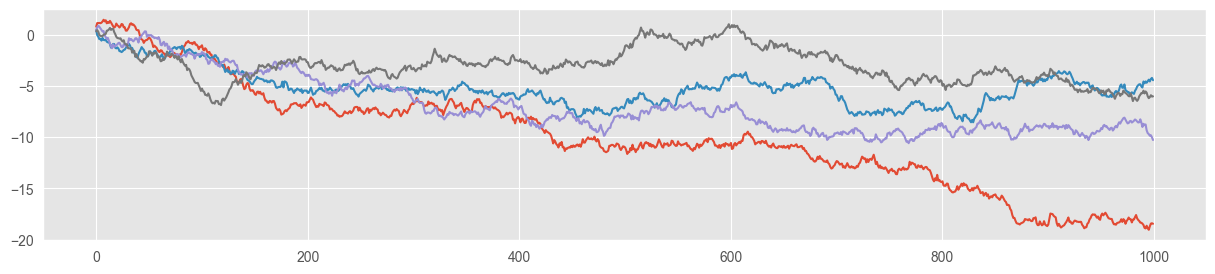

In [4]:
def plot_random_walk( sigma=0.2 ):
    pi = np.random.rand()
    chain = []
    for i in range(1000):
        pi = propose_jump( pi, sigma=sigma )
        chain.append( pi )
    plt.plot( chain )

plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )
plot_random_walk( sigma=0.2 )

### c) Jump decision

**Jump decision**

In the Metropolis algorithm with a symmetric proposal distribution, the random walk is
**nudged towards the posterior** by an acceptance rule.

Given:

- current value $\pi$ in the chain,
- proposed value $\pi'$ from the proposal distribution,

we define the **acceptance probability**

$$
\alpha
= \min\!\left\{ 1,\,
    \frac{p(\pi') \, P(Y = k \mid \pi')}
         {p(\pi) \, P(Y = k \mid \pi)}
  \right\}.
$$

Here,

- $p(\pi)$ is the **prior density** $\mathrm{Beta}(\alpha,\beta)$ (e.g. via `stats.beta.pdf()`),
- $P(Y = k \mid \pi)$ is the **binomial likelihood** (e.g. via `stats.binom.pmf()`).

Then sample $u \sim \operatorname{Uniform}(0,1)$ (e.g. with `np.random.rand()`) and use the
decision rule:

- If $u \le \alpha$: accept the jump and return $\pi'$.
- If $u > \alpha$: reject the jump and stay at $\pi$.

Implement a function

```python
decide(pi, pi2, alpha, beta, n, k)
```

where `pi` is the current value, `pi2` is the proposal, `alpha` and `beta` define the beta
prior, and `n`, `k` describe the binomial data. Use the Metropolis decision rule above to
return either `pi2` or `pi`.

**Hints.**

- You may print or return $\alpha$ for debugging and sanity checks.
- If the proposal $\pi'$ lies outside $[0,1]$, it must be **rejected** (because $\pi$ is
  defined only on this interval).

In [5]:
def decide( pi, pi2, alpha, beta, n, k, debug=False ):
    # evaluate prior and likelihood
    prior1 = stats.beta.pdf( pi, alpha, beta )
    prior2 = stats.beta.pdf( pi2, alpha, beta )
    likelihood1 = stats.binom.pmf( n=n, k=k, p=pi )
    likelihood2 = stats.binom.pmf( n=n, k=k, p=pi2 )

    # define alpha
    alpha = min( 1, prior2/prior1 * likelihood2/likelihood1 )
    if debug: print("pi = {:.5f}, pi2 = {:.5f}, alpha = {:.5f}".format(pi, pi2, alpha))

    # jump decision
    p = np.random.rand()
    if p<=alpha and 0 < pi2 < 1:
        return pi2
    else:
        return pi

pi = 0.2
pi2 = propose_jump( pi, sigma=0.2 )
decide( pi, pi2, alpha, beta, n, k , debug=True)

pi = 0.20000, pi2 = -0.05245, alpha = 1.00000


0.2

### d) Single-chain MCMC

**Single-chain Metropolis algorithm**

Now combine everything into a full implementation of the **single-chain Metropolis algorithm**.

- Create an empty list `chain`.
- Randomly initialize $\pi$ in the interval $[0,1]$.
- For `n_steps` iterations, repeat:
  1. Propose a jump with `propose_jump()`.
  2. Decide to accept or reject with `decide()`.
  3. Append the current $\pi$ (after the decision) to `chain`.

Encapsulate the code in a function

```python
metropolis_chain(n_steps, alpha, beta, n, k, sigma)
```

that returns the full chain (list or array of length `n_steps`). Generate a chain with
$n_\text{steps} = 1000$.

In [6]:
def metropolis_chain( n_steps, alpha, beta, n, k, sigma ):
    
    # initialize
    pi = np.random.rand()
    chain = []
    accepted = 0

    # create chain
    for i in tqdm( range( n_steps ) ):
        pi2 = propose_jump( pi, sigma )
        pi = decide( pi, pi2, alpha, beta, n, k )
        chain.append( pi )
        
    return chain

chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.2 )
len( chain )

100%|██████████| 1000/1000 [00:00<00:00, 6870.36it/s]


1000

### e) Verification

**Verification of your implementation**

Now verify that your `metropolis_chain()` works as intended.

1. **Hyperparameter tuning (trace plot)**  
   - Visualize your chain with a trace plot (plot chain value vs. iteration).
   - If the chain mixes **too slowly** (strong autocorrelation, moves are tiny), the
     acceptance rate is probably too high: try **increasing** $\sigma$.
   - If the chain often stays at the same value (many rejections), the acceptance rate
     is too low: try **decreasing** $\sigma$.
   - Choose a value of $\sigma$ such that the trace looks healthy.

2. **Visualizing the posterior distribution**  
   - Plot a **histogram** (as a density) of the chain values.
   - On top of that, plot the PDF of the **analytical posterior**
     $$
     \pi \mid Y = k \sim \mathrm{Beta}(\alpha + k,\; \beta + n - k).
     $$
   - Check whether the empirical distribution of your MCMC samples roughly matches the
     analytical posterior.

#### Trace plot:

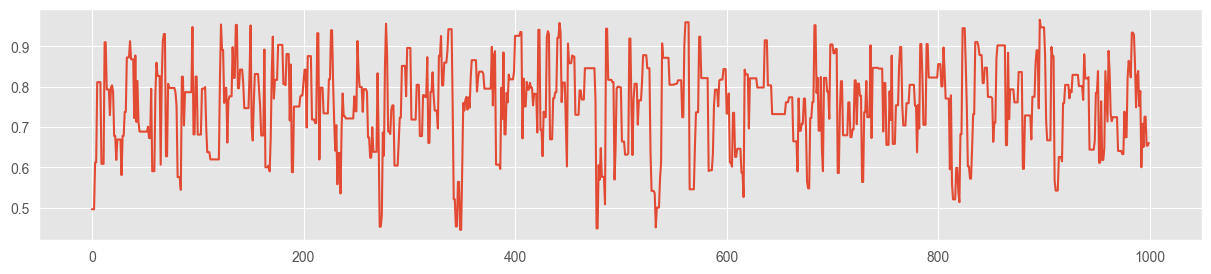

In [7]:
plt.plot( chain )

(looks ok - otherwise tune $\sigma$ as done in the next part)

#### Step 1 (hyperparameter tuning): Try out other values of sigma

100%|██████████| 1000/1000 [00:00<00:00, 6960.07it/s]


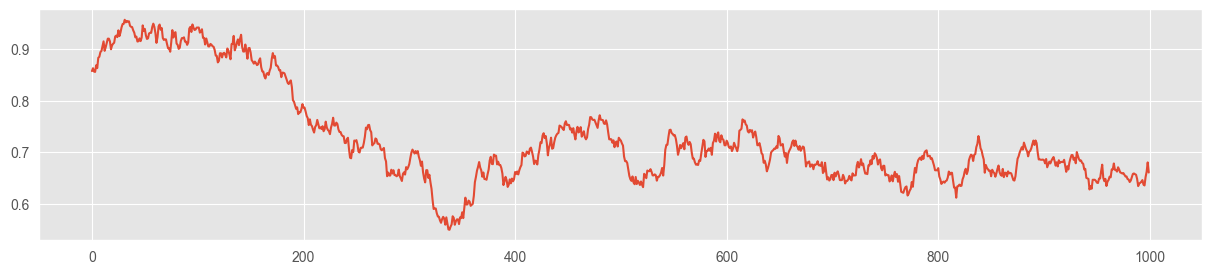

In [8]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.01 )
plt.plot( chain )

Example for slow mixing - sigma is too small and the chain explores the parameter space only slowly.

100%|██████████| 1000/1000 [00:00<00:00, 7683.51it/s]


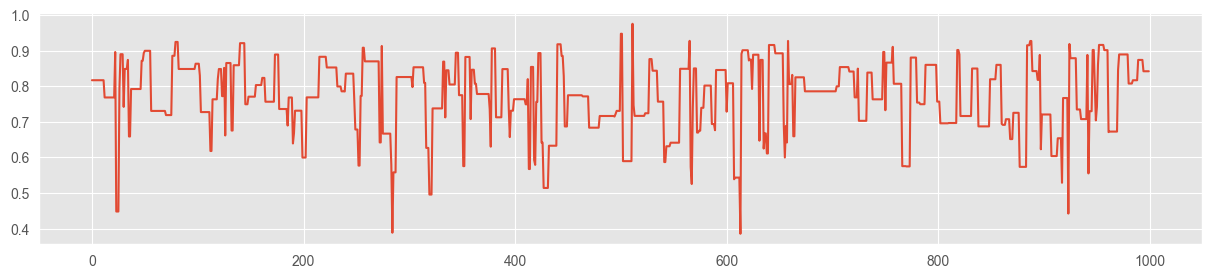

In [9]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.5 )
plt.plot( chain )

The chain is often stuck. High rejection rate because sigma is too large and most of the proposals land far away from the mass of the posterior.

`sigma = 0.2` seems more or less ok:

100%|██████████| 1000/1000 [00:00<00:00, 7016.33it/s]


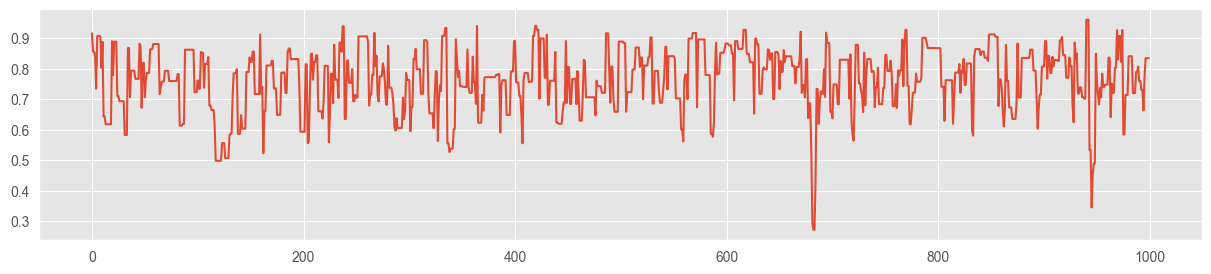

In [10]:
chain = metropolis_chain( 1000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

#### Step 2: Visualize distribution

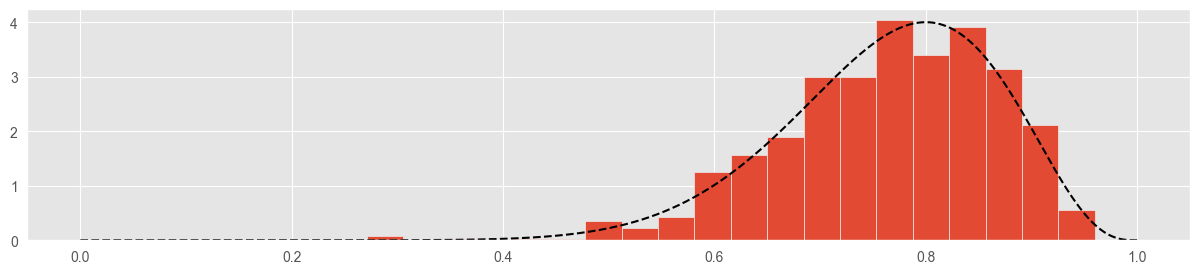

In [11]:
# histogram
plt.hist( chain, density=True, bins=20 )

# true posterior
pi_range = np.linspace(0, 1, 1000)
true_posterior = [stats.beta.pdf(pi, alpha+k, beta+n-k) for pi in pi_range]
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Seems more or less ok! Try with more samples:

100%|██████████| 4000/4000 [00:00<00:00, 6799.25it/s]


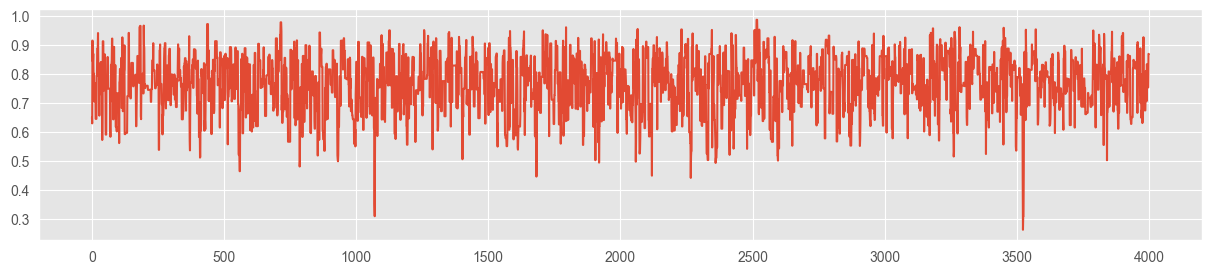

In [12]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

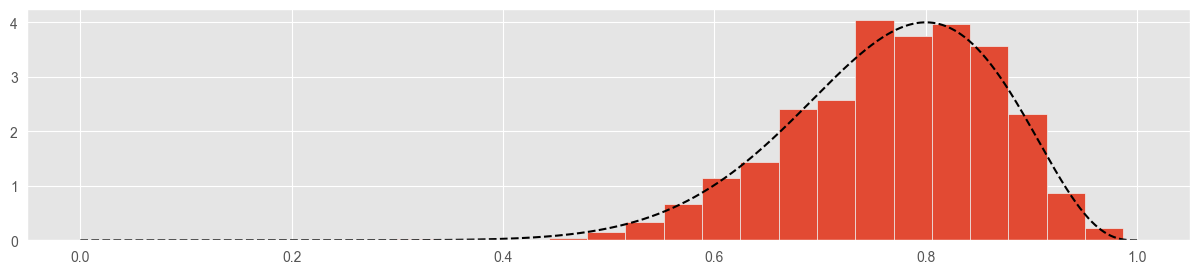

In [13]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Looks good!

### f) Playing around

**Playing around with the proposal scale**

Experiment with different values of the proposal standard deviation $\sigma$:

- What happens to the **trace plot** if $\sigma$ is very small or very large?
- What happens to the **histogram** of the samples?

Discuss:

- How does too small $\sigma$ affect exploration and autocorrelation?
- How does too large $\sigma$ affect the acceptance rate and the shape of the sampled
  distribution?
- How do you recognize a “reasonably chosen” $\sigma$ (even without looking at the true
  closed-form posterior)?

#### `sigma` much too low:

100%|██████████| 4000/4000 [00:00<00:00, 6524.23it/s]


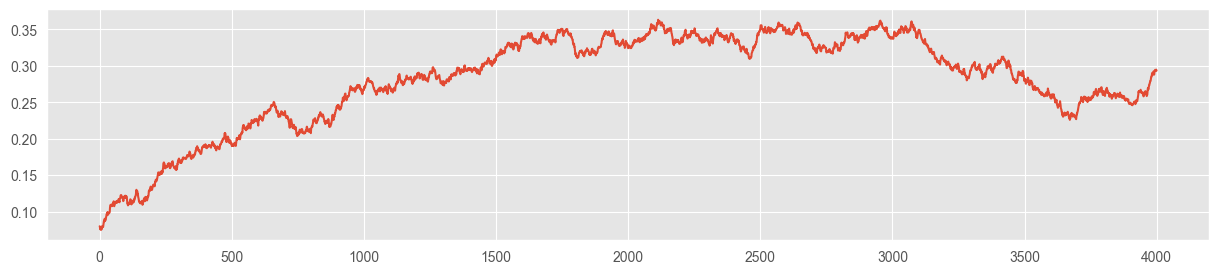

In [14]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.002 )
plt.plot( chain )

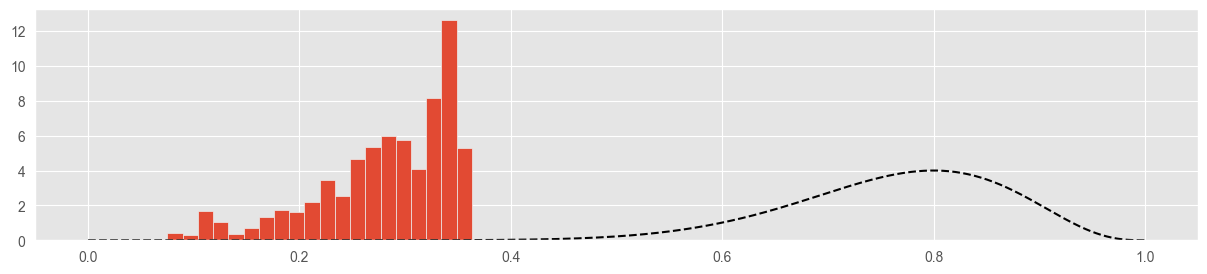

In [15]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Chain explores only a small part of the parameter space! Acceptance rate is very high because chain always climbs up towards the mode with very small steps. However it barely reaches it.

#### `sigma` much too high:

100%|██████████| 4000/4000 [00:00<00:00, 9428.67it/s]


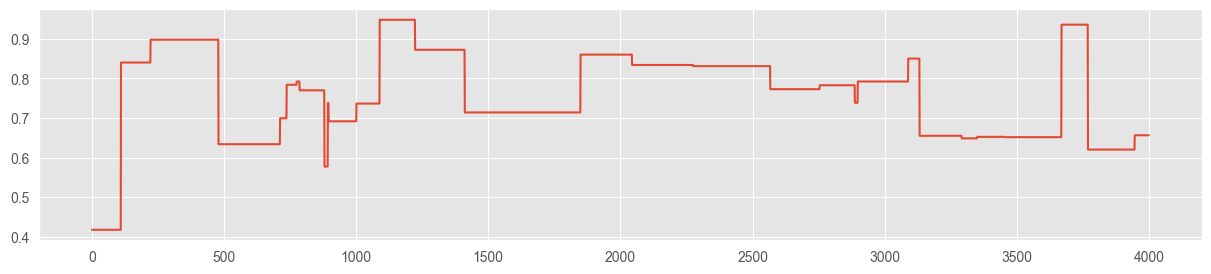

In [16]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=20 )
plt.plot( chain )

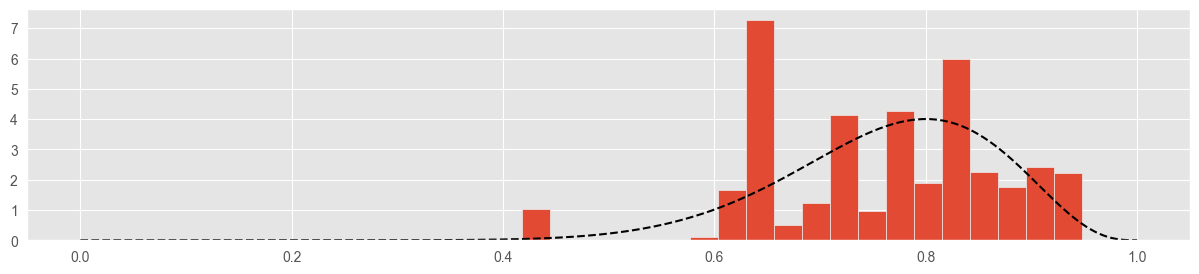

In [17]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

Chain is mostly stuck at the same point and most of the proposals are rejected. Because of this, we only get a few independent samples and the density is concentrated and exaggerated around the points where the chain was stuck.

#### `sigma` just right:

100%|██████████| 4000/4000 [00:00<00:00, 6891.24it/s]


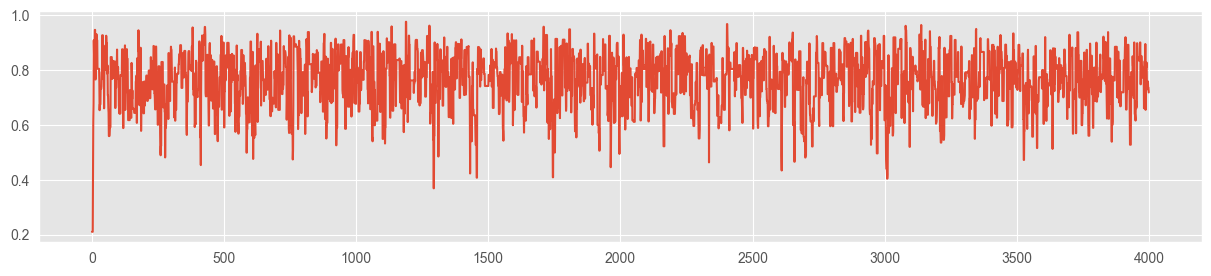

In [18]:
chain = metropolis_chain( 4000, alpha, beta, n, k, sigma=0.2 )
plt.plot( chain )

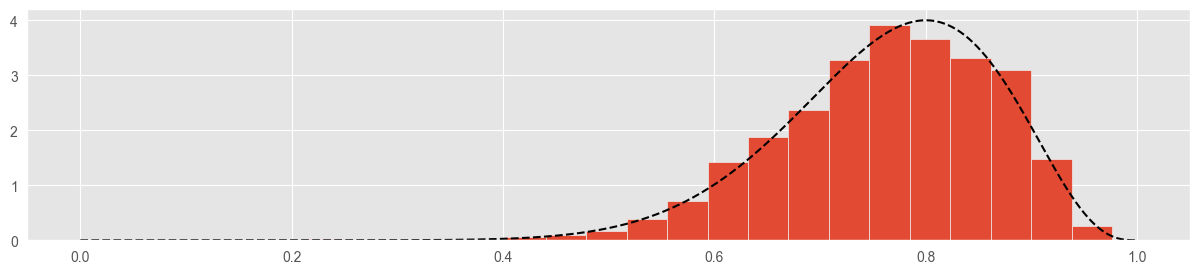

In [19]:
plt.hist( chain, density=True, bins=20 )
plt.plot( pi_range, true_posterior, c="black", ls="--" )

The trace plot looks completely random (not stuck, not creeping), the true distribution is approximated quite nicely.

## Exercise 2

In the previous exercise you used a **single** Metropolis chain and its trace plot as a diagnostic
for mixing. In this exercise you will work with **multiple Metropolis chains** in parallel and
investigate additional diagnostics, in particular a simplified version of the $\hat R$ statistic.

We keep the same beta–binomial model as before and focus on comparing chains started from
different initial values.

### a) Multiple chains

**Multiple chains**

Write a function

```python
metropolis(n_chains, n_steps, alpha, beta, n, k, sigma)
```

that runs `n_chains` independent Metropolis chains (e.g. start with 4 chains). Each chain
should be created using your `metropolis_chain()` function from Exercise 1.

Your function should return a NumPy array of shape `(n_steps, n_chains)` containing all
chains, which you will use in the subsequent parts.

In [20]:
def metropolis( n_chains, n_steps, alpha, beta, n, k, sigma ):
    res = [metropolis_chain( n_steps, alpha, beta, n, k, sigma ) for i in range( n_chains)]
    return np.array(res).T # to have chains in columns

sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )
sim.shape

100%|██████████| 4000/4000 [00:00<00:00, 6763.62it/s]


(4000, 4)

### b) Trace plots

**Trace plots**

Visualize all four trace plots of your chains (e.g. in a single figure with four panels), using
your “best” value of $\sigma$ from the previous exercise.

- Do the chains appear to explore the same region of the posterior?
- Does each chain mix reasonably well, without getting stuck?

Use the trace plots as a qualitative convergence diagnostic.

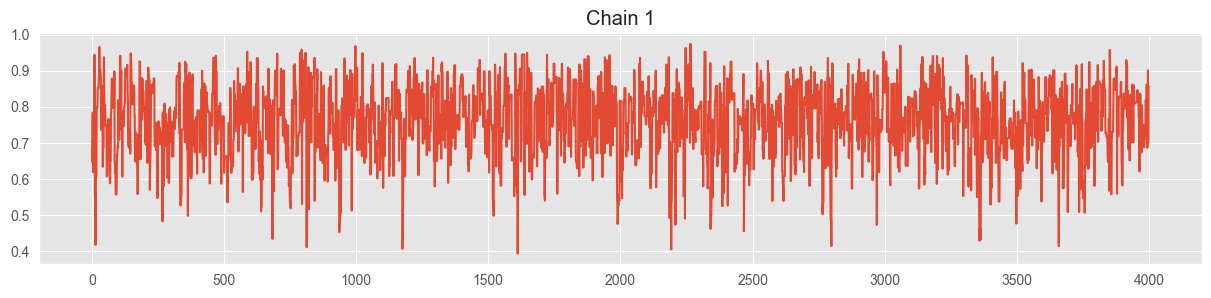

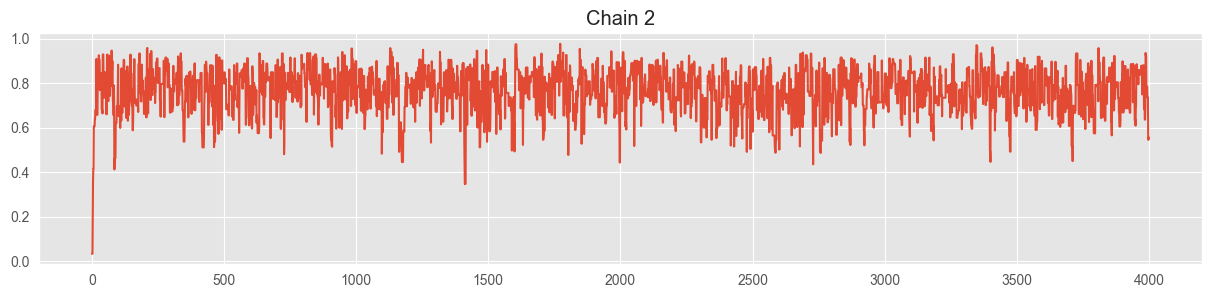

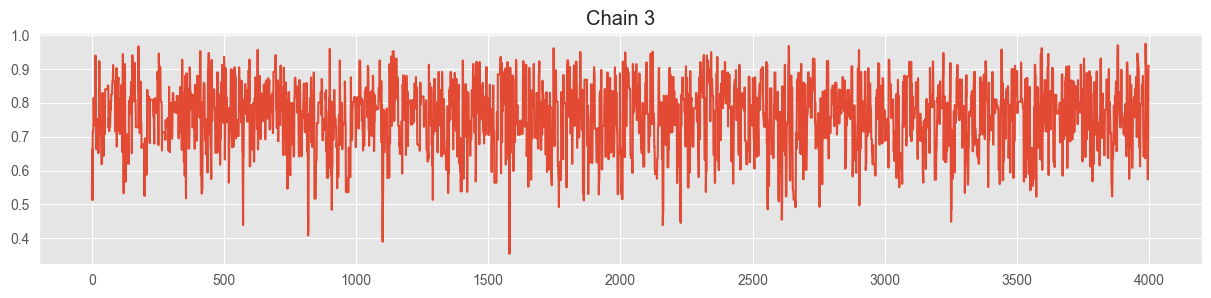

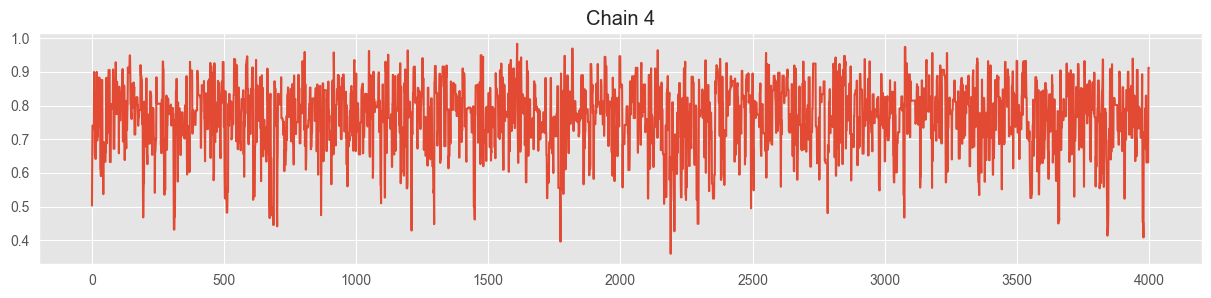

In [21]:
for i in range( sim.shape[1] ):
    plt.figure()
    plt.plot( sim[:,i] )
    plt.title("Chain {}".format(i+1))

Looks ok!

### c) Density plots

**Density plots**

For each chain, visualize its marginal distribution using a **density plot**, e.g. with
`seaborn.kdeplot()`.

- Are the estimated densities for the four chains in reasonable agreement?
- What happens to the densities if you choose $\sigma$ **too large** or **too small**?

Use these density plots to complement the trace plots and assess whether different chains
converged to the same posterior distribution.

#### `sigma` just right:

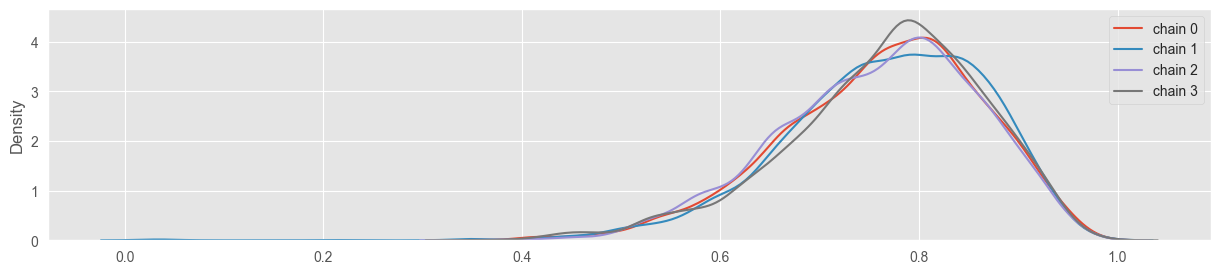

In [22]:
def density_plots( sim ):
    for i in range( sim.shape[1] ):
        sns.kdeplot( sim[:,i], label="chain {}".format(i) )
    plt.legend()

density_plots( sim )

Chains have converged quite well!

#### `sigma` too small:

100%|██████████| 4000/4000 [00:00<00:00, 6647.44it/s]


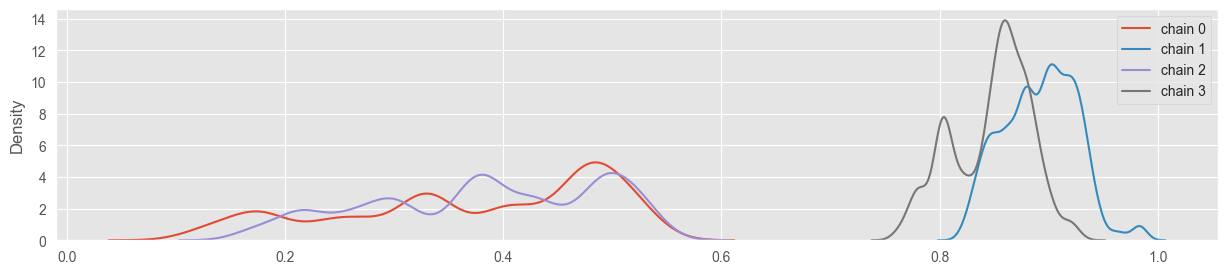

In [23]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.002 )
density_plots( sim )

Chains have not converged yet and explore different regions of the parameter space.

#### `sigma` too large:

100%|██████████| 4000/4000 [00:00<00:00, 9028.72it/s]


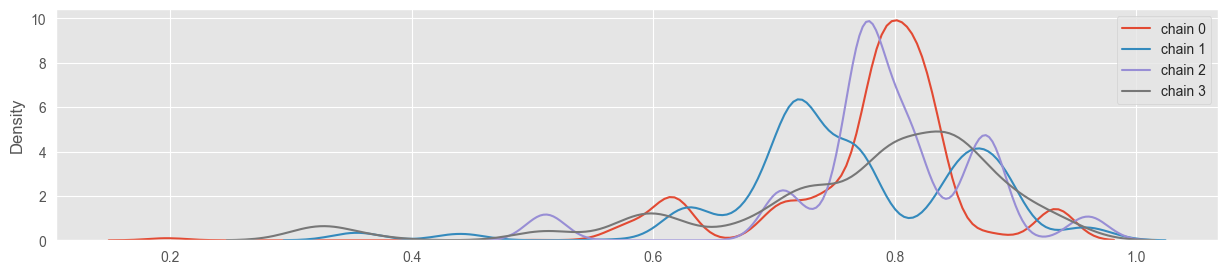

In [24]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=20 )
density_plots( sim )

Chains have not coverged - density plot is misleading, chains are stuck at single points.

### d) $\hat{R}$

**$\hat R$ diagnostic**

In the lecture we discussed $\hat R$ as a quantitative measure of convergence between chains.
Here you will compute a simplified version:

Let $x_i$ denote the list (vector) of values in chain $i$, and let $x$ denote the concatenation
of all chains. Define

$$
\hat R
= \sqrt{
    \frac{\operatorname{Var}(x)}{
      \frac{1}{n_{\text{chains}}}
      \sum_i \operatorname{Var}(x_i)
    }
  }.
$$

Compute $\hat R$ for your output, for your “optimal” value of $\sigma$, and study how $\hat R$
changes when you make $\sigma$ too small or too large.

- What are typical values of $\hat R$ for well-mixing chains in this simple problem?
- Is $\hat R$ alone sufficient to distinguish good from bad chains, or do you still need to
  look at trace plots and densities?

In [25]:
def rhat( sim ):
    total_var = np.var( sim.flatten() )
    individual_var = np.var( sim, axis=0 )
    rhat = np.sqrt( total_var / np.mean(individual_var) )
    return rhat

sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )
rhat( sim )

100%|██████████| 4000/4000 [00:00<00:00, 6870.80it/s]


1.00035941252993

Very close to 1, this is a sign for a healthy chain!

#### `sigma` too small:

In [26]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.002 )
rhat( sim )

100%|██████████| 4000/4000 [00:00<00:00, 6514.84it/s]


4.487446479917157

Rhat is much larger than 1 - this is a sign for a very unhealthy chain!

#### `sigma` too large:

In [27]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=20 )
rhat( sim )

100%|██████████| 4000/4000 [00:00<00:00, 9005.56it/s]


1.0102319835225078

Rhat is quite small - however the chains have not converged well! Therefore Rhat alone cannot be used as a single diagnostic, evidence of the unhealthiness can only be found in the trace plot in this case (also an autocorrelation plot and effective sample size could be valuable tools here). 

### e) Burn-in phase

**Burn-in phase**

Discuss whether a **burn-in phase** (discarding the first part of each chain) is relevant for
your beta–binomial problem with the chosen priors and data.

- Use your trace plots to argue whether the chains quickly forget their initial values.
- Would discarding some iterations at the beginning substantially change your posterior
  summaries in this case?

Let's come back to our healthy chain:

In [28]:
sim = metropolis( 4, 4000, alpha, beta, n, k, sigma=0.2 )

100%|██████████| 4000/4000 [00:00<00:00, 6887.33it/s]


Trace plot of first chain (only beginning):

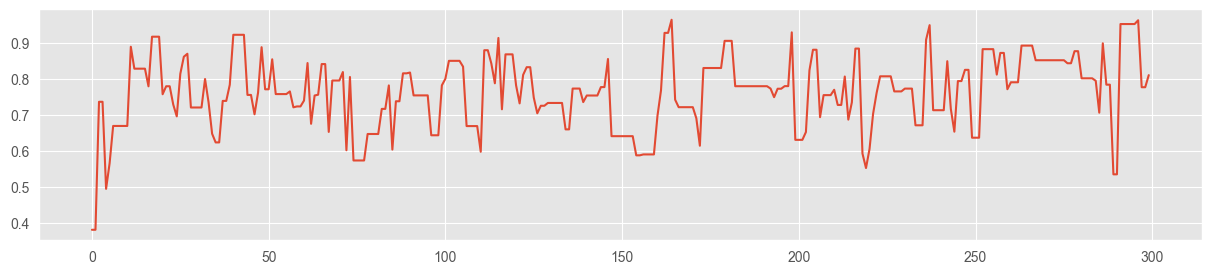

In [29]:
plt.plot( sim[:300,0] )

Since the beta-binomial posterior has a very smooth, one-dimensional probability surface, the Metropolis algorithm finds the mode quickly and appears to require only around 10 samples of burn-in time (depending on the initial value). In the overall size of the chain the burn-in phase can be neglected in this case. This is different for more complicated, multivariate problems!

## Exercise 3

In Exercises 1 and 2 you implemented your own Metropolis sampler and basic diagnostics
(trace plots, densities, a simplified $\hat R$). In this exercise you will reproduce the analysis
using **PyMC**, which automates most of the MCMC details.

You will see how PyMC

- runs multiple chains,
- provides convenient access to posterior samples,
- and offers a variety of built-in diagnostics and visualizations.

### a)

**Reproducing the analysis with PyMC**

Build the same beta–binomial model in PyMC as in the previous exercises:

- Prior: $\pi \sim \mathrm{Beta}(\alpha,\beta)$,
- Likelihood: $Y \mid \pi \sim \operatorname{Bin}(n,\pi)$ with observed $Y = k$.

Use `pm.sample()` to draw posterior samples and reproduce the results from Exercise 2
(trace plots and densities) to demonstrate that PyMC performs essentially the same MCMC
operations for you, given that you specify prior and likelihood.

In [30]:
import pymc as pm
with pm.Model() as beta_binom_model:
    pi = pm.Beta( 'pi', alpha=alpha, beta=beta )
    y = pm.Binomial( 'y', p=pi, n=n, observed=k )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


PyMC gives you 4 chains by default and is using the NUTS algorithm in this case.

### b)

**Accessing samples for $\pi$**

Investigate the structure of the object returned by `pm.sample()` (e.g. an ArviZ `InferenceData`
object). Figure out how to **extract the samples** for the parameter $\pi$ from this object.

- How are chains and draws organized in the data structure?
- How can you convert them to a NumPy array if needed?

The output of PyMC is an xarray object. Let's have a look at it:

In [31]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [32]:
trace.posterior

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    pi       (chain, draw) float64 32kB 0.7144 0.7144 0.925 ... 0.8774 0.8175
Attributes:
    created_at:                 2025-11-09T11:21:14.479647
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.12.0
    sampling_time:              0.40617799758911133
    tuning_steps:               1000

In [33]:
sim = trace.posterior.pi.values
sim.shape

(4, 1000)

This gets us back the values in the chain we produced previously.

### c)

**MCMC diagnostics with PyMC / ArviZ**

Using PyMC's own plotting functions or the corresponding ArviZ functions, produce the
following diagnostics for $\pi$ and check whether they look healthy:

- Trace plot and density plot,
- Autocorrelation plot,
- Effective sample size (ESS),
- $\hat R$ (Rhat).

If you have `graphviz` installed, also call `pm.model_to_graphviz()` on your model and
interpret the graphical representation:

- What do the nodes represent?
- What is the meaning of the arrow in this simple model?

Trace and density plot:

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

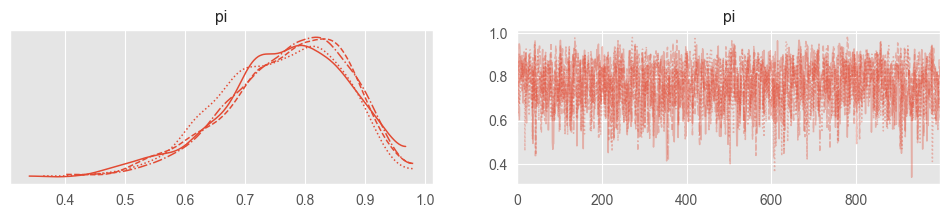

In [34]:
pm.plot_trace( trace )

Autocorrelation plot (all chains combined):

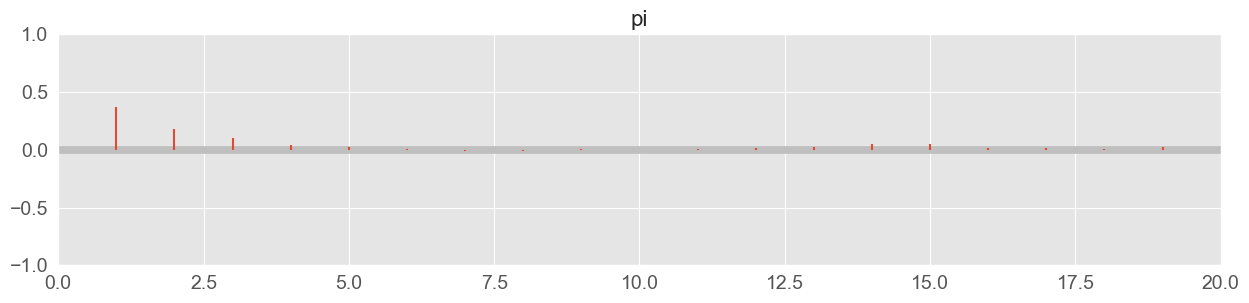

In [35]:
pm.plot_autocorr( trace, combined=True, max_lag=20 );

Drops off extremely quickly!

Effective sample size (ESS):

In [36]:
ess = pm.ess( trace ).pi.values
ess

array(1621.68294897)

Considerably lower than 4000! ESS ratio:

In [37]:
ess / 4000

0.40542073724190125

Much larger than the required 10%!

Rhat:

In [38]:
pm.rhat( trace ).pi.values

array(1.0033117)

Looks good! (<< 1.05)

Model graph:

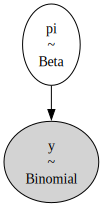

In [39]:
pm.model_to_graphviz( beta_binom_model )

Arrow: the likelihood Bin$(Y=y|\pi)$ depends on $\pi$ (that is modelled by a prior).

### d)

**Rank plots (trank plots)**

Some practitioners argue that **rank plots** (or trank plots) are better at revealing problems
with chains than trace plots.

- Find out what a rank plot is and how it is constructed.
- Use PyMC / ArviZ to generate a rank plot for your simulation.
- Does the rank plot confirm that your chains look well-mixed in this simple example?

array([[<Axes: title={'center': 'pi'}>,
        <Axes: title={'center': 'pi'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

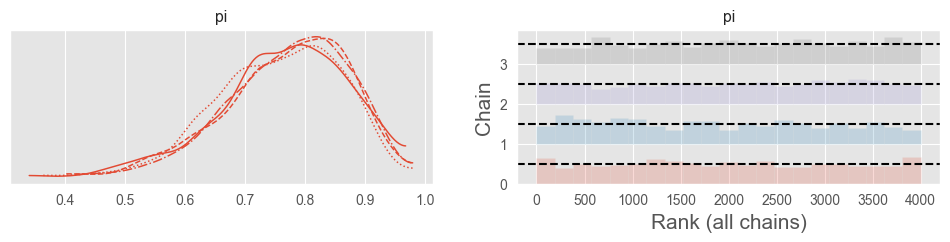

In [40]:
pm.plot_trace( trace, kind="rank_bars" )

The rank (or trank) plot does the following: 
1. Rank the samples from all chains from 1 to 4000 (number samples used here)
2. For each chain individually, produce a histogram of its ranks

For healthy, well-mixing chains, the histograms should be uniform. A spike indicates that the chain got stuck somwhere (producing too many samples of one particular value of $\pi$. Any other asymmetries indicate that the chains did not explore the same regions of the parameter space.

The rank plot above looks good!

More details: Vehtari, Gelman, Simpson, Carpenter, Bürkner. 2019. Rank-normalization, folding, and localization: An improved R-hat for assessing convergence of MCMC. https://arxiv.org/abs/1903.08008

### e)

**Alternative prior: truncated normal**

A coworker argues that a **truncated normal** distribution with mean $\mu = 0.8$ and standard
deviation $\sigma = 0.2$, truncated to the interval $[0,1]$, better reflects their prior belief
about $\pi$. Investigate this alternative prior and compare it with your beta prior.

1. Do some research on the definition and properties of a truncated normal distribution.
2. Use PreliZ (or a similar tool) to visualize both your beta prior and your coworker's
   truncated normal prior and compare them visually.
3. Run a new PyMC simulation using the truncated normal prior and compare the resulting
   posterior density for $\pi$ with the beta-prior-based posterior.
4. Use `pm.summary()` (or `az.summary()`) to provide a numerical comparison:
   - Does it matter much which of the two priors you use in this example?
   - Compare also **bulk ESS** and **tail ESS** (what are they, and what does it mean if
     they differ?).

Discuss in which situations the difference between these priors might become important,
and when it is practically negligible.

Plot truncated normal prior:

<Axes: >

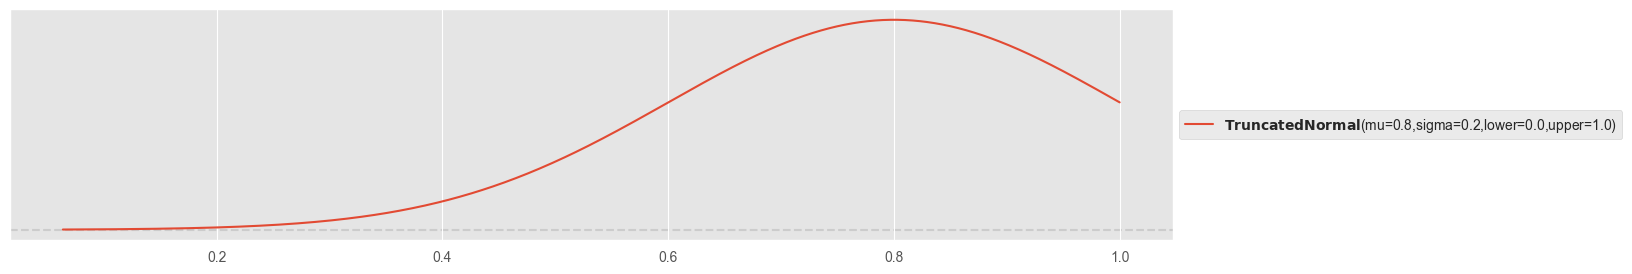

In [41]:
pz.TruncatedNormal( mu=0.8, sigma=0.2, lower=0, upper=1 ).plot_pdf()

Plot previous prior:

<Axes: >

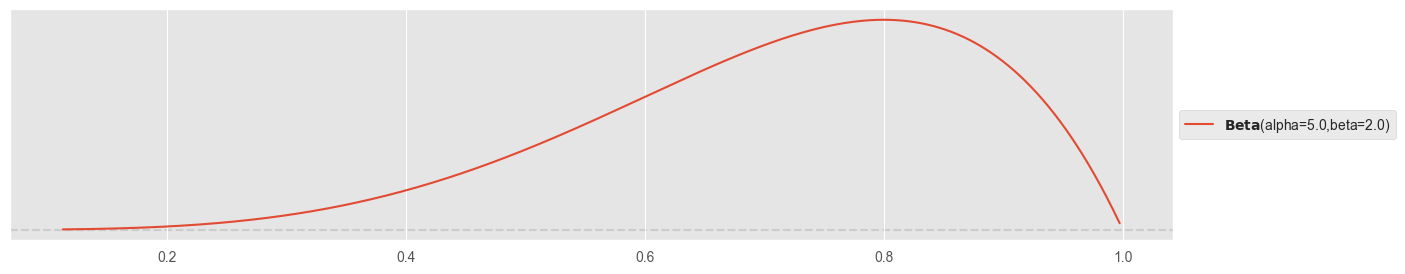

In [42]:
pz.Beta( alpha=alpha, beta=beta ).plot_pdf()

Run simulation with truncated normal prior:

In [43]:
with pm.Model() as normal_binom_model:
    pi = pm.TruncatedNormal( 'pi', mu=0.8, sigma=0.2, lower=0, upper=1 )
    y = pm.Binomial( 'y', p=pi, n=n, observed=k )
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Compare densities:

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

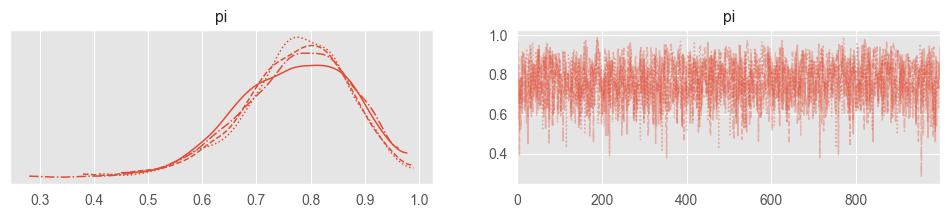

In [44]:
pm.plot_trace( trace2 )

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

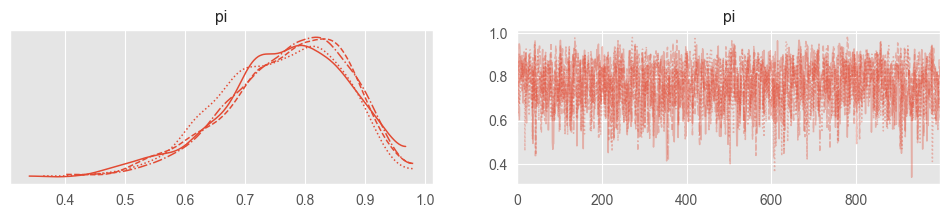

In [45]:
pm.plot_trace( trace )

Compare summaries:

In [46]:
pm.summary( trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.771,0.1,0.581,0.94,0.002,0.002,1645.0,1962.0,1.0


In [47]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.766,0.101,0.585,0.947,0.002,0.002,1622.0,2146.0,1.0


The resulting densities are very similar! It appears that the simulation with the truncated normal prior is numerically a bit less effective, with $\sim400$ less effective samples both in the bulk (center of the distribution) and the tails (periphery). This means that the beta prior produces more accurate estimates at the same computational effort!

## Exercise 4

A company produces **ceramic containers** for foundries and wants to know the **maximum
temperature** such a container can tolerate, together with the **uncertainty** about this value.
Since testing the maximum temperature destroys a container, the number of measurements
should be as small as possible.

Your team has collected $10$ measurements of the maximum tolerable temperature (in degrees
Celsius):

$$
y = [1055,\; 1053,\; 1226,\; 967,\; 980,\; 1049,\; 1040,\; 1051,\; 1002,\; 1057].
$$

You consider the following model:

- Prior for the mean:
  $$
  \mu \sim \mathcal{N}(\theta, \tau^2),
  $$
- Prior for the standard deviation:
  $$
  \sigma \sim \operatorname{Exp}(1/\lambda),
  $$
- Likelihood:
  $$
  y \mid \mu, \sigma \sim \mathcal{N}(\mu, \sigma^2).
  $$

Your prior expectations are:

- for $\mu$: a normal prior with $\theta = 1000^\circ\text{C}$ and $\tau = 100^\circ\text{C}$,
- for $\sigma$: an exponential prior with scale parameter $\lambda = 100^\circ\text{C}$.

This is the first time you encounter a model with **multiple parameters** to estimate
simultaneously. Instead of specifying one joint two-dimensional prior for $(\mu,\sigma)$, you
assume **independence** and define two separate priors; such factorizations will be discussed
in more detail later in the course.

### a)

**Prior for $\sigma$ and role of the exponential distribution**

Read about the **exponential distribution** and its parameterization. For a rate parameter
$\lambda > 0$, the exponential distribution has density

$$
f(\sigma)
= \lambda \exp(-\lambda \sigma),
\quad \sigma \ge 0.
$$

In our notation, $\sigma \sim \operatorname{Exp}(1/\lambda)$ corresponds to an exponential
distribution with mean $\lambda$.

- What is the role of $\lambda$ in shaping the prior for $\sigma$?
- Does this prior favor smaller or larger values relative to $\lambda$?

Visualize $\operatorname{Exp}(1/100)$ with PreliZ. Argue why a **normal** or **beta**
distribution would *not* be suitable as a prior for $\sigma$ in this context (e.g., support of
the distribution, possibility of negative values, etc.).

<Axes: >

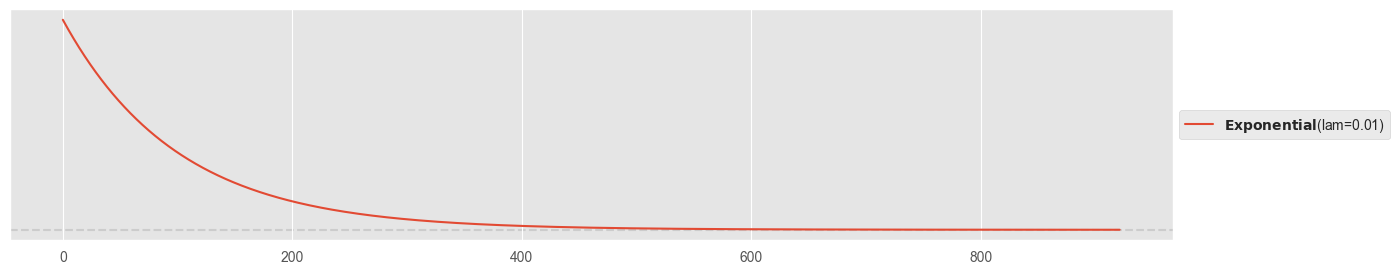

In [48]:
pz.Exponential(1/100).plot_pdf()

In [49]:
pz.Exponential(1/100).mean()

100.0

If $\sigma \sim \text{Exp}(1/\lambda)$, then $E[\sigma] = \lambda$ (see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Exponential_distribution)). Since the exponential distribution is right-skewed, prior values below $100^\circ$ C are favored to values above $100^\circ$ C. 

A normal distribution can't be used as prior for $\sigma$, since it could also produce negative values, and $\sigma$ is strictly positive. A beta distribution is restricted to values between 0 and 1 and $\sigma$ is most likely not. The exponential distribution suits well here, as it produces positive numbers.

### b)

**PyMC model and posterior summaries**

Carefully implement the model in PyMC using the given priors and likelihood, and run MCMC
sampling.

- Verify convergence of your chains using a **rank plot** (trank plot).
- Use `pm.summary()` (or `az.summary()`) to compute posterior summaries for $\mu$ and $\sigma$.

Compare your **posterior expectations** for $\mu$ and $\sigma$ with the **prior expectations**:

- How did your understanding of the average maximum temperature change?
- How did your uncertainty (posterior vs. prior variability) change?

In [50]:
observations = [1055, 1053, 1226,  967,  980, 1049, 1040, 1051, 1002, 1057]

with pm.Model() as normal_normal_model:
    mu = pm.Normal( 'mu', mu=1000, sigma=100 )
    sigma = pm.Exponential( 'sigma', 1/100 )
    y = pm.Normal( 'y', mu=mu, sigma=sigma, observed=observations )
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


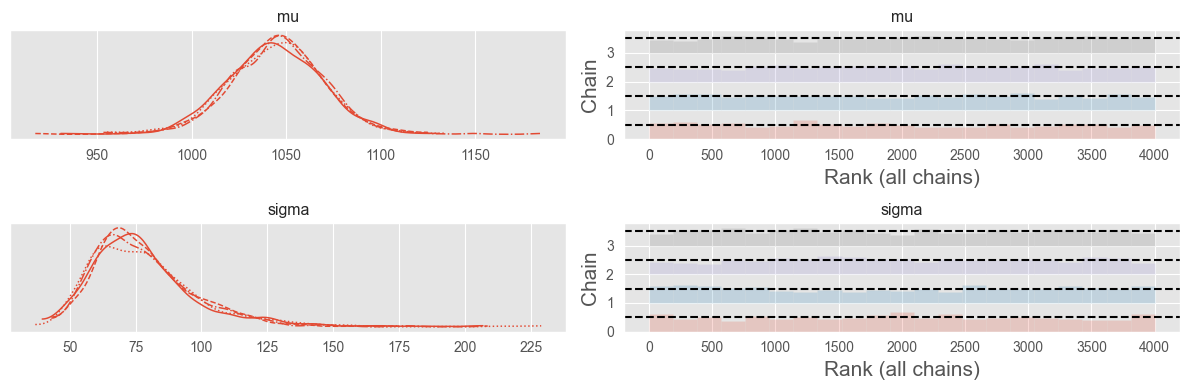

In [51]:
pm.plot_trace( trace, kind="rank_bars" )
plt.tight_layout()

Looks good!

In [52]:
pm.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1044.708,24.875,995.915,1088.634,0.479,0.339,2730.0,2326.0,1.0
sigma,78.141,20.472,46.665,115.806,0.460,0.346,2398.0,1926.0,1.0


Your understanding of mean maximum temperature increased from $\mu=1000$ to $\mu=1046$, while your understanding of uncertainty $\sigma$ on this mean maximum temperature decreased from $\sigma=100^\circ$ C to $\sigma=78^\circ$ C.

### c)

**Graphical model representation**

If you have `graphviz` installed, use

```python
pm.model_to_graphviz(model)
```

to visualize your PyMC model.

- How does the graph relate to the textual model specification
  $\mu \sim \mathcal{N}(\theta,\tau^2)$, $\sigma \sim \operatorname{Exp}(1/\lambda)$,
  $y \mid \mu,\sigma \sim \mathcal{N}(\mu,\sigma^2)$?
- Which nodes are stochastic, which are observed, and how are they connected?

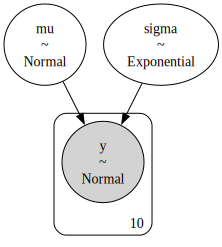

In [53]:
pm.model_to_graphviz( normal_normal_model )

### d)

**Two-dimensional view of the chain**

Extract the first $100$ samples for $\mu$ and $\sigma$ from the **first chain** of your PyMC
trace and plot them in a **two-dimensional** diagram that shows the evolution of the chain in
parameter space (for example, connect successive $(\mu,\sigma)$ pairs with line segments).

- Do you see evidence of a **warm-up phase** in the trajectory?
- How does this warm-up phase differ conceptually from the **burn-in** of simpler Metropolis
  algorithms? (Hint: advanced algorithms such as NUTS use a warm-up phase mainly to tune
  hyperparameters rather than to “find” the posterior mass.)

Extract Numpy arrays for mu and sigma:

In [54]:
mu_chain = trace.posterior.mu.values
sigma_chain = trace.posterior.sigma.values
mu_chain.shape, sigma_chain.shape

((4, 1000), (4, 1000))

2D plot of parameter space:

Text(0, 0.5, '$\\sigma$')

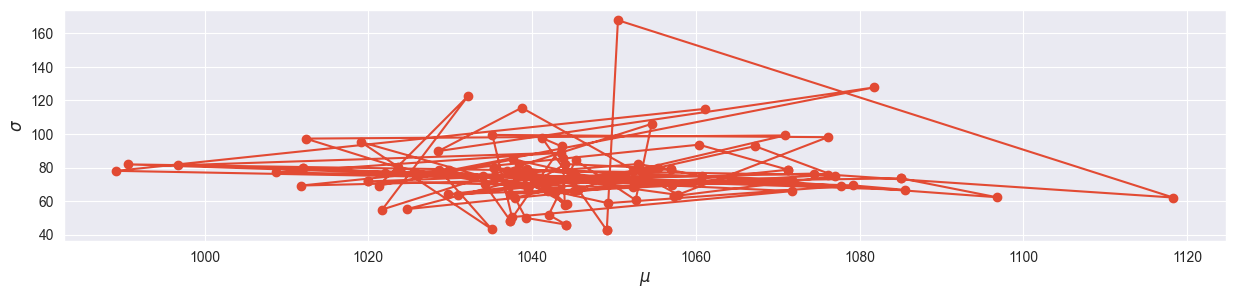

In [55]:
plt.plot( mu_chain[0,:100], sigma_chain[0,:100], marker="o" )
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")

The warm-up phase can clearly be located away from the mode!